In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore") 

import numpy as np
import pandas as pd
import re
from datetime import datetime

import matplotlib.pyplot as plt
import seaborn as sns

import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from string import punctuation

import language_check

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.externals import joblib
from sklearn.model_selection import train_test_split

import warnings
warnings.simplefilter("ignore", DeprecationWarning)

In [2]:
training_set  = pd.read_csv('training_set_rel3.tsv', sep='\t', encoding = "ISO-8859-1")\
            .rename(columns={'essay_set': 'topic', 'domain1_score': 'target_score', 'domain2_score': 'topic2_target'})
training_set.head()

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,Unnamed: 0.1.1.1,Unnamed: 0.1.1.1.1,essay_id,topic,essay,rater1_domain1,rater2_domain1,...,rater3_trait2,rater3_trait3,rater3_trait4,rater3_trait5,rater3_trait6,err_ratio,avg_len,total_err_ratio,avg_wdlen,count_vector
0,0,0,0,0,0,1,1,"Dear local newspaper, I think effects computer...",4,4,...,NaN,NaN,NaN,NaN,NaN,"(0.026627218934911243, 0.005917159763313609)",30.818182,0.032544,4.387574,"(0, 19929)\t1\n (0, 13868)\t1\n (0, 33918)..."
1,1,1,1,1,1,2,1,"Dear @CAPS1 @CAPS2, I believe that using compu...",5,4,...,NaN,NaN,NaN,NaN,NaN,"(0.03341288782816229, 0.011933174224343675)",22.052632,0.045346,4.353222,"(0, 20235)\t1\n (0, 26185)\t1\n (0, 26031)..."
2,2,2,2,2,2,3,1,"Dear, @CAPS1 @CAPS2 @CAPS3 More and more peopl...",4,3,...,NaN,NaN,NaN,NaN,NaN,"(0.0035842293906810036, 0.02867383512544803)",18.533333,0.032258,4.405018,"(0, 36230)\t1\n (0, 29755)\t1\n (0, 7980)\..."
3,3,3,3,3,3,4,1,"Dear Local Newspaper, @CAPS1 I have found that...",5,5,...,NaN,NaN,NaN,NaN,NaN,"(0.04580152671755725, 0.02099236641221374)",21.040000,0.066794,4.868321,"(0, 34683)\t1\n (0, 21557)\t1\n (0, 8232)\..."
4,4,4,4,4,4,5,1,"Dear @LOCATION1, I know having computers has a...",4,4,...,NaN,NaN,NaN,NaN,NaN,"(0.025806451612903226, 0.010752688172043012)",14.903226,0.036559,4.408602,"(0, 36306)\t1\n (0, 22533)\t1\n (0, 28070)..."


# Essay processing:
Language correction with languagetool (add number of corrections as feature)
Sentence tokenization with Spacy
Sentence count and length
Word tokenize with Spacy
Word token classification (punctuation, stop words and anonymized entities, pos, ent)
Document similarity (based on arbitrary high scoring essay for each topic)

## Grammar and spelling
As to be expected with student essays, many essays exhibit grammar and spelling errors.

Parts-of-speech (POS) and named-entity-recognition (NER) is hampered in part by the lack of consitent spelling and punctuation. Therefore, the essays will be corrected using languagetool and the nlp parsing will be performed with Spacy on the corrected essays.

In [3]:
import language_check

In [4]:
tool = language_check.LanguageTool('en-US')

In [5]:
training_set.essay

0        Dear local newspaper, I think effects computer...
1        Dear @CAPS1 @CAPS2, I believe that using compu...
2        Dear, @CAPS1 @CAPS2 @CAPS3 More and more peopl...
3        Dear Local Newspaper, @CAPS1 I have found that...
4        Dear @LOCATION1, I know having computers has a...
5        Dear @LOCATION1, I think that computers have a...
6        Did you know that more and more people these d...
7        @PERCENT1 of people agree that computers make ...
8        Dear reader, @ORGANIZATION1 has had a dramatic...
9        In the @LOCATION1 we have the technology of a ...
10       Dear @LOCATION1, @CAPS1 people acknowledge the...
11       Dear @CAPS1 @CAPS2 I feel that computers do ta...
12       Dear local newspaper I raed ur argument on the...
13       My three detaileds for this news paper article...
14       Dear, In this world today we should have every...
15       Dear @ORGANIZATION1, The computer blinked to l...
16       Dear Local Newspaper, I belive that computers .

In [6]:
#example of language check
text = training_set.essay[123]
matches = tool.check(text)
text=language_check.correct(text, matches)
text

"I think that the computers are good to be used because anybody can use them at anytime or go on it whenever they want to. The reason why I think it is good is because you can contact someone that you know and talk to them whenever you want. Another reason is because you can play games or look for something or even make research on stuff that you want to know or about something that you were always curious about. A computer is also useful for better things like using it for when going to work or when a kid in school needs to do a report of project and needs to do it in typing and also to save stuff that you don't want anybody to use. Computers can sometimes be helpful to people that really need it and that actually need to use it, but it can also be a fun activity to do if anybody doesn't have nothing to do. I think that the computer is awesome because anybody enough can open up their own website and create something what. A lot of people can go on the internet and open an account on a

In [7]:
# use language tool to correct for most spelling and grammatical errors. Also count the applied corrections. 
# Using language_check python wrapper for languagetool:
# https://www.languagetool.org/dev

tool = language_check.LanguageTool('en-US')

t0 = datetime.now()

training_set['matches'] = training_set['essay'].apply(lambda txt: tool.check(txt))
training_set['corrections'] = training_set.apply(lambda l: len(l['matches']), axis=1)
training_set['corrected'] = training_set.apply(lambda l: language_check.correct(l['essay'], l['matches']), axis=1)

t1 = datetime.now()
print('Processing time: {}'.format(t1 - t0))

# # save work
training_set.to_pickle('training_corr.pkl')

Processing time: 0:15:41.152830


In [8]:
def cal_err_ratio(essay):
    matches = tool.check(essay)
    n_typos=0
    n_others=0
    for m in matches:
        if m.ruleId=="MORFOLOGIK_RULE_EN_US":
            n_typos=n_typos+1
        else:
            n_others=n_others+1
    length = len(essay.split())
    return n_typos/length, n_others/length
def cal_avg_len(essay):
    matches = tool.check(essay)
    essay = language_check.correct(essay, matches)
    wordnum=len(essay.split())
    sennum=len(essay.split("."))
    return wordnum/sennum

In [ ]:
err_ratio=[]
avg_len=[]
for es in training_set.essay:
    err_ratio.append(cal_err_ratio(es))
    avg_len.append(cal_avg_len(es))

In [ ]:
s = "string. With. Punctuation?"
s = re.sub(r'[^\w\s]','',s)
s

In [ ]:
%%time
def cal_avg_wdlen(essay):
    total_wdlen=0
    words=essay.split()
    for word in words:
        word_without_pun=re.sub(r'[^\w\s]','',word)
        total_wdlen+=len(word_without_pun)
    return total_wdlen/len(words)
avg_wdlen=[]
for es in training_set.essay:
    avg_wdlen.append(cal_avg_wdlen(es))

In [ ]:
training_set['avg_wdlen']=avg_wdlen

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
corpus=list(training_set.essay)
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(corpus)

In [ ]:
wd_matrix=X.toarray()

In [ ]:
count_vector = pd.DataFrame()

In [ ]:
for i in range(len(wd_matrix[0])):
    n_elements = []
    for j in wd_matrix:
        n_elements.append(j[i])
    count_vector.insert(loc=i,column="w_vector"+str(i),value=n_elements)

In [ ]:
count_vector.to_csv('count_vector.tsv', sep='\t', encoding = "ISO-8859-1")

## features vs. score

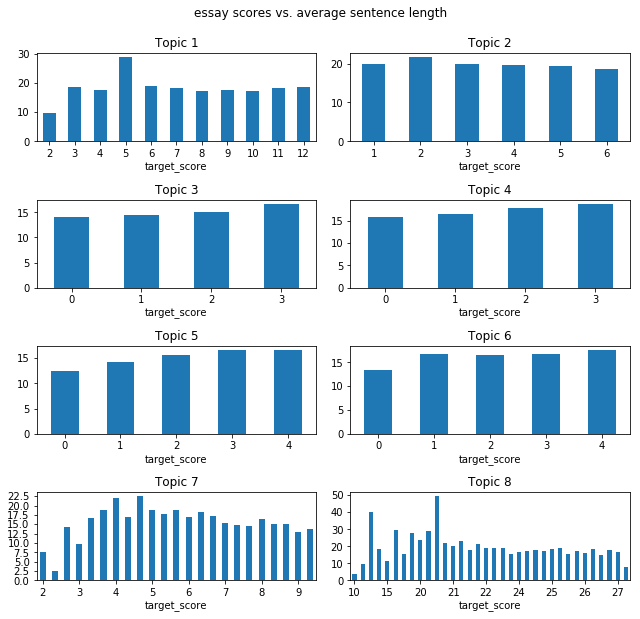

In [10]:
def plot_scores_vs_features(features):
    topic_number = 0
    fig, ax = plt.subplots(4,2, figsize=(9,9), sharey=False)
    for i in range(4):
        for j in range(2):
            topic_number += 1
            features[features['topic'] == topic_number]\
                .groupby('target_score')['avg_len']\
                .agg('mean')\
                .plot.bar(ax=ax[i, j], rot=0)
            ax[i,j].set_title('Topic %i' % topic_number)
    ax[3,0].locator_params(nbins=10)
    ax[3,1].locator_params(nbins=10)
    plt.suptitle('essay scores vs. average sentence length')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()
plot_scores_vs_features(training_set)

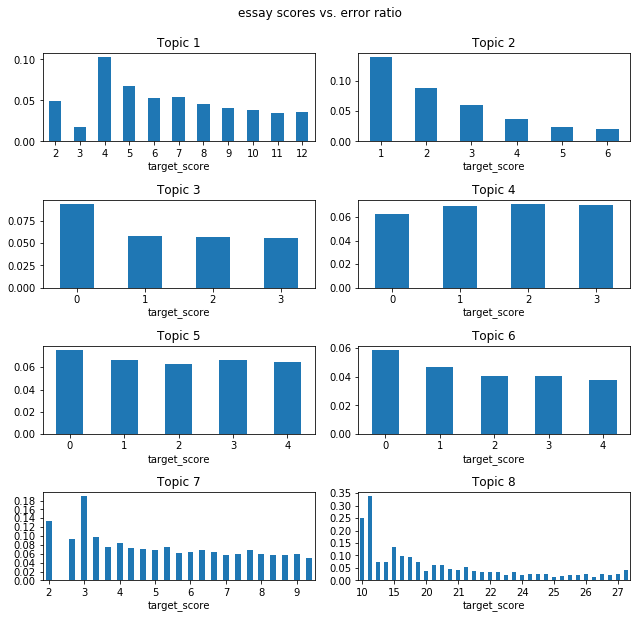

In [11]:
def plot_scores_vs_features(features):
    topic_number = 0
    fig, ax = plt.subplots(4,2, figsize=(9,9), sharey=False)
    for i in range(4):
        for j in range(2):
            topic_number += 1
            features[features['topic'] == topic_number]\
                .groupby('target_score')['total_err_ratio']\
                .agg('mean')\
                .plot.bar(ax=ax[i, j], rot=0)
            ax[i,j].set_title('Topic %i' % topic_number)
    ax[3,0].locator_params(nbins=10)
    ax[3,1].locator_params(nbins=10)
    plt.suptitle('essay scores vs. error ratio')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()
plot_scores_vs_features(training_set)

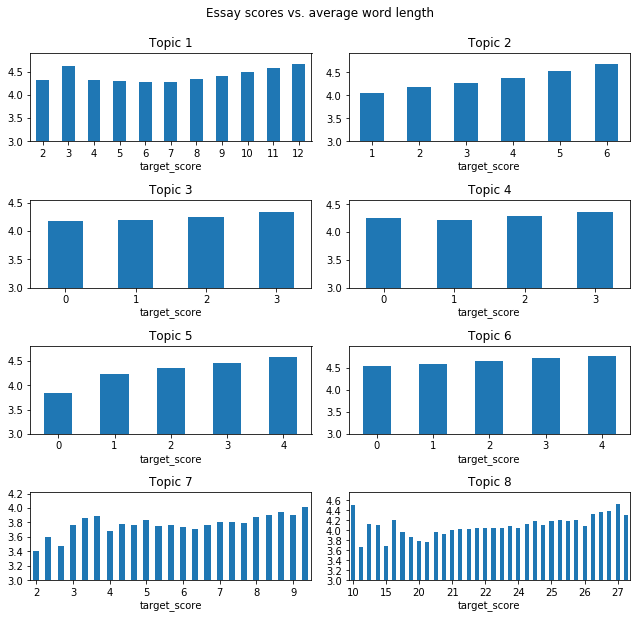

In [12]:
def plot_scores_vs_features(features):
    topic_number = 0
    fig, ax = plt.subplots(4,2, figsize=(9,9), sharey=False)
    for i in range(4):
        for j in range(2):
            topic_number += 1
            features[features['topic'] == topic_number]\
                .groupby('target_score')['avg_wdlen']\
                .agg('mean')\
                .plot.bar(ax=ax[i, j], rot=0)
            ax[i,j].set_title('Topic %i' % topic_number)
            ax[i,j].set_ylim(bottom=3)
    ax[3,0].locator_params(nbins=10)
    ax[3,1].locator_params(nbins=10)
    plt.suptitle('Essay scores vs. average word length')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()
plot_scores_vs_features(training_set)

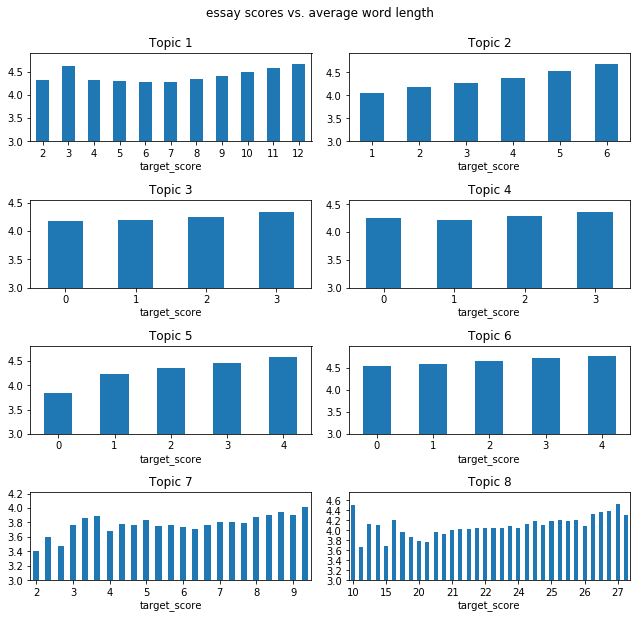

In [13]:
def plot_scores_vs_features(features):
    topic_number = 0
    fig, ax = plt.subplots(4,2, figsize=(9,9), sharey=False)
    for i in range(4):
        for j in range(2):
            topic_number += 1
            features[features['topic'] == topic_number]\
                .groupby('target_score')['avg_wdlen']\
                .agg('mean')\
                .plot.bar(ax=ax[i, j], rot=0)
            ax[i,j].set_title('Topic %i' % topic_number)
            ax[i,j].set_ylim(bottom=3)
    ax[3,0].locator_params(nbins=10)
    ax[3,1].locator_params(nbins=10)
    plt.suptitle('essay scores vs. average word length')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()
plot_scores_vs_features(training_set)

# NLP with SpaCy

In [ ]:
sents = []
tokens = []
lemma = []
pos = []
ner = []

stop_words = set(STOP_WORDS)
stop_words.update(punctuation) # remove it if you need punctuation 

nlp = spacy.load('en_core_web_sm')

t0 = datetime.now()

# suppress numpy warnings
np.warnings.filterwarnings('ignore')

i = 1
#for essay in nlp.pipe(training_set['corrected'], batch_size=100, n_threads=3):
for essay in nlp.pipe(training_set['corrected'], batch_size=100):
    print(i)
    i += 1
    if essay.is_parsed:
        tokens.append([e.text for e in essay])
        sents.append([sent.string.strip() for sent in essay.sents])
        pos.append([e.pos_ for e in essay])
        ner.append([e.text for e in essay.ents])
        lemma.append([n.lemma_ for n in essay])
    else:
        # We want to make sure that the lists of parsed results have the
        # same number of entries of the original Dataframe, so add some blanks in case the parse fails
        tokens.append(None)
        lemma.append(None)
        pos.append(None)
        sents.append(None)
        ner.append(None)

training_set['tokens'] = tokens
training_set['lemma'] = lemma
training_set['pos'] = pos
training_set['sents'] = sents
training_set['ner'] = ner

t1 = datetime.now()
print('Processing time: {}'.format(t1 - t0))

In [ ]:
training_set.to_pickle('training_spacy.pkl')

In [ ]:
training_set = pd.read_pickle('training_spacy.pkl')

In [ ]:
training_set[['tokens', 'pos', 'sents', 'ner']].head()